In [3]:
import numpy as np
import mne
from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import pickle
import visualkeras

In [4]:
K.set_image_data_format('channels_last')

In [5]:
# Load the preprocessed data
with open('preprocessed_data.pkl', 'rb') as f:
    X, y = pickle.load(f)

In [6]:
# Check the shapes of the datasets
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (37075, 64, 737)
y shape: (37075,)


In [7]:
# Ensure that the number of samples is correct for y
if X.shape[0] != y.shape[0]:
    raise ValueError("Mismatch between number of samples in X and y.")

In [20]:
# Define parameters
kernels, chans, samples = 1, X.shape[1], X.shape[2]

print(kernels, chans, samples)

1 64 737


In [9]:
# Split data into train, validate, and test sets (adjust as needed)
train_size = int(0.5 * len(X))
validate_size = int(0.25 * len(X))

In [10]:
print("train_size:", train_size)
print("validate_size:", validate_size)
print("test_size:", len(y) - train_size - validate_size)

train_size: 18537
validate_size: 9268
test_size: 9270


In [11]:
X_train = X[:train_size]
Y_train = y[:train_size]
X_validate = X[train_size:train_size + validate_size]
Y_validate = y[train_size:train_size + validate_size]
X_test = X[train_size + validate_size:]
Y_test = y[train_size + validate_size:]

In [12]:
# Check the shapes of the splits before one-hot encoding
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_validate shape:", X_validate.shape)
print("Y_validate shape:", Y_validate.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (18537, 64, 737)
Y_train shape: (18537,)
X_validate shape: (9268, 64, 737)
Y_validate shape: (9268,)
X_test shape: (9270, 64, 737)
Y_test shape: (9270,)


In [13]:
print(y.shape)
print(X.shape)
print(train_size)
print(validate_size)

(37075,)
(37075, 64, 737)
18537
9268


In [14]:
# One-hot encode the labels
Y_train = np_utils.to_categorical(Y_train)
Y_validate = np_utils.to_categorical(Y_validate)
Y_test = np_utils.to_categorical(Y_test)

In [15]:
# Reshape data for EEGNet
X_train = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test = X_test.reshape(X_test.shape[0], chans, samples, kernels)

In [16]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (18537, 64, 737, 1)
18537 train samples
9270 test samples


In [19]:
print('Y_train shape', Y_train.shape)
print('Y_test shape', Y_test.shape)

Y_train shape (18537, 6)
Y_test shape (9270, 6)


In [17]:
# Initialize EEGNet model
model = EEGNet(nb_classes=Y_train.shape[1], Chans=chans, Samples=samples,
               dropoutRate=0.5, kernLength=32, F1=8, D=2, F2=16,
               dropoutType='Dropout')

In [18]:
visualkeras.layered_view(model, to_file='model.png').show()

In [24]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up model checkpointing
checkpointer = ModelCheckpoint(filepath='./tmp/checkpoint.h5', verbose=1, save_best_only=True)

# Train the model
fittedModel = model.fit(X_train, Y_train, batch_size=16, epochs=300, verbose=2,
                        validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer])


Epoch 1/300

Epoch 1: val_loss improved from inf to 1.30228, saving model to /tmp\checkpoint.h5
1159/1159 - 163s - loss: 1.3670 - accuracy: 0.4980 - val_loss: 1.3023 - val_accuracy: 0.5172 - 163s/epoch - 141ms/step
Epoch 2/300


c:\temp\BME_442\bme442projectMain\venv-3.10.5\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.30228 to 1.24780, saving model to /tmp\checkpoint.h5
1159/1159 - 147s - loss: 1.2577 - accuracy: 0.5129 - val_loss: 1.2478 - val_accuracy: 0.5287 - 147s/epoch - 127ms/step
Epoch 3/300

Epoch 3: val_loss improved from 1.24780 to 1.22602, saving model to /tmp\checkpoint.h5
1159/1159 - 149s - loss: 1.2235 - accuracy: 0.5273 - val_loss: 1.2260 - val_accuracy: 0.5449 - 149s/epoch - 129ms/step
Epoch 4/300

Epoch 4: val_loss improved from 1.22602 to 1.18757, saving model to /tmp\checkpoint.h5
1159/1159 - 152s - loss: 1.1960 - accuracy: 0.5383 - val_loss: 1.1876 - val_accuracy: 0.5496 - 152s/epoch - 131ms/step
Epoch 5/300

Epoch 5: val_loss improved from 1.18757 to 1.16781, saving model to /tmp\checkpoint.h5
1159/1159 - 152s - loss: 1.1695 - accuracy: 0.5525 - val_loss: 1.1678 - val_accuracy: 0.5506 - 152s/epoch - 131ms/step
Epoch 6/300

Epoch 6: val_loss improved from 1.16781 to 1.15738, saving model to /tmp\checkpoint.h5
1159/1159 - 162s - loss: 1.1482 - ac

KeyboardInterrupt: 

In [25]:
# Load best weights
model.load_weights('./tmp/checkpoint.h5')

In [3]:
# Print checkpoint folder full path
print("Model checkpoint folder:", os.path.abspath('./tmp/checkpoint.h5'))

Model checkpoint folder: c:\temp\BME_442\bme442projectMain\tmp\checkpoint.h5


In [26]:
# Evaluate model
probs = model.predict(X_test)
preds = probs.argmax(axis=-1)
acc = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

290/290 [==============================] - 9s 31ms/step
Classification accuracy: 0.567422 


In [27]:
# PyRiemann part (for comparison)
n_components = 2
clf = make_pipeline(XdawnCovariances(n_components), TangentSpace(metric='riemann'), LogisticRegression())
X_train_reshaped = X_train.reshape(X_train.shape[0], chans, samples)
X_test_reshaped = X_test.reshape(X_test.shape[0], chans, samples)
clf.fit(X_train_reshaped, Y_train.argmax(axis=-1))
preds_rg = clf.predict(X_test_reshaped)
acc2 = np.mean(preds_rg == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc2))

c:\temp\BME_442\bme442projectMain\venv-3.10.5\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification accuracy: 0.474757 


In [28]:
# Plot confusion matrices
names = ['rest', 'left fist', 'right fist', 'both fists', 'both feet']

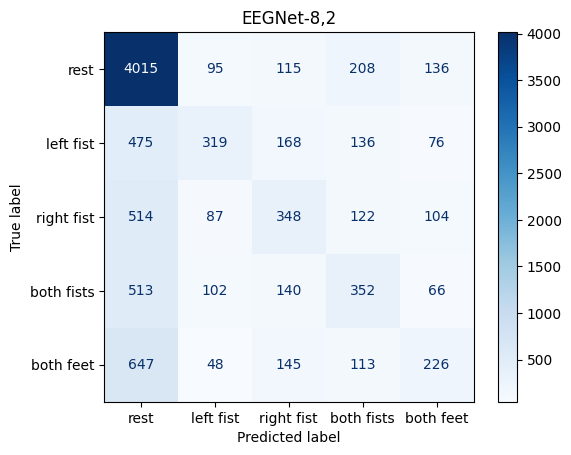

In [29]:
cm_eegnet = confusion_matrix(Y_test.argmax(axis=-1), preds)
disp_eegnet = ConfusionMatrixDisplay(confusion_matrix=cm_eegnet, display_labels=names)
disp_eegnet.plot(cmap=plt.cm.Blues)
plt.title('EEGNet-8,2')
plt.show()

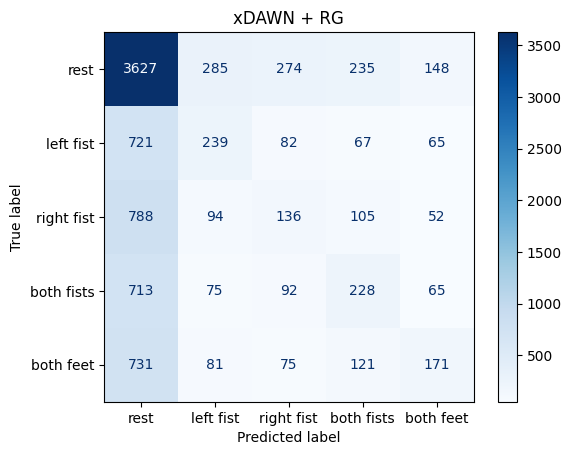

In [30]:
cm_rg = confusion_matrix(Y_test.argmax(axis=-1), preds_rg)
disp_rg = ConfusionMatrixDisplay(confusion_matrix=cm_rg, display_labels=names)
disp_rg.plot(cmap=plt.cm.Blues)
plt.title('xDAWN + RG')
plt.show()